In [70]:
import numpy as np

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
Draw.SetComicMode(IPythonConsole.drawOptions)
%load_ext sql

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
plt.rcParams['font.size'] = '16'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [2]:
%sql postgresql://glandrum@stoat/chembl_33 \
  drop table if exists assay_counts
    
%sql postgresql://glandrum@stoat/chembl_33 \
  select assays.chembl_id,assay_id,count(distinct molregno) cnt into temporary table assay_counts \
      from assays join activities using (assay_id) \
                  join docs on (assays.doc_id = docs.doc_id) \
      where standard_type='Ki' and \
      assays.doc_id is not null and doi is not null and year is not null\
      group by (assays.chembl_id,assay_id);

aids = %sql postgresql://glandrum@stoat/chembl_33 \
    select * from assay_counts where cnt>20 and cnt<100;
len(aids)

Done.
53801 rows affected.
7148 rows affected.


7148

In [48]:
aids[:4]

[('CHEMBL857972', 157, 66),
 ('CHEMBL615643', 393, 24),
 ('CHEMBL615557', 535, 71),
 ('CHEMBL615558', 536, 30)]

In [49]:
import random
random.seed(0xC0FFEE)
random.shuffle(aids)
aids[:4]

[('CHEMBL1176478', 642589, 29),
 ('CHEMBL902340', 453190, 32),
 ('CHEMBL3877023', 1634231, 21),
 ('CHEMBL1959874', 807746, 36)]

In [61]:
aid = 'CHEMBL1803423'  # this was the first hit from ChEMBL 32
aid = aids[0][0]
structs = %sql postgresql://glandrum@stoat/chembl_33 \
  select distinct on (canonical_smiles) cids.chembl_id compound_chembl_id,canonical_smiles \
    from activities \
        join assays using (assay_id) \
        join compound_structures using (molregno) \
        join chembl_id_lookup cids on (molregno=entity_id and entity_type='COMPOUND')\
    where assays.chembl_id=:aid \
      and standard_type='Ki'
len(structs)
    

29 rows affected.


29

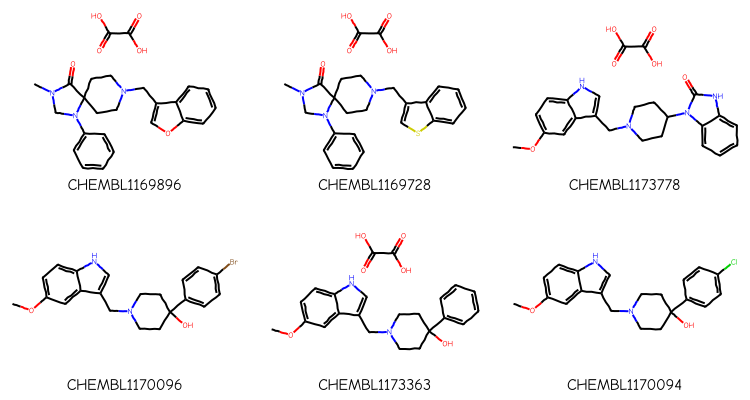

In [57]:
nms,smis = zip(*structs)
mols = [Chem.MolFromSmiles(x) for x in smis]
Draw.MolsToGridImage(mols[:6],legends=nms,subImgSize=(250,200))

In [58]:
scaffs = []
for m in mols:
    scaff = Chem.MurckoDecompose(m)
    Chem.SanitizeMol(scaff)
    scaffs.append(scaff)
scaff_smis = [Chem.MolToSmiles(x) for x in scaffs]
len(set(scaff_smis))

12

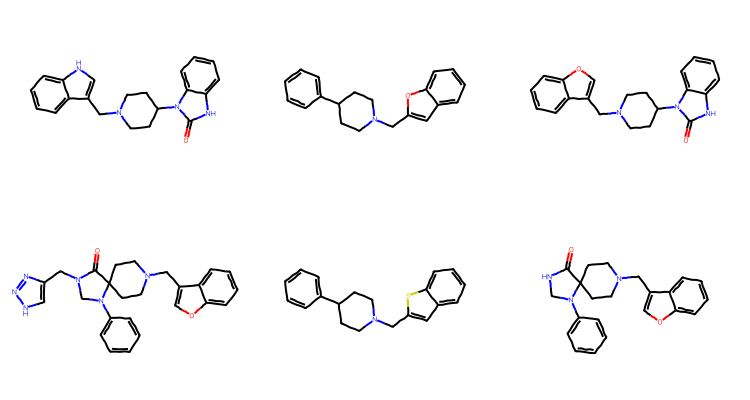

In [59]:
unique_scaffs = [Chem.MolFromSmiles(smi) for smi in set(scaff_smis)]
Draw.MolsToGridImage(unique_scaffs[:6],subImgSize=(250,200))

32 rows affected.


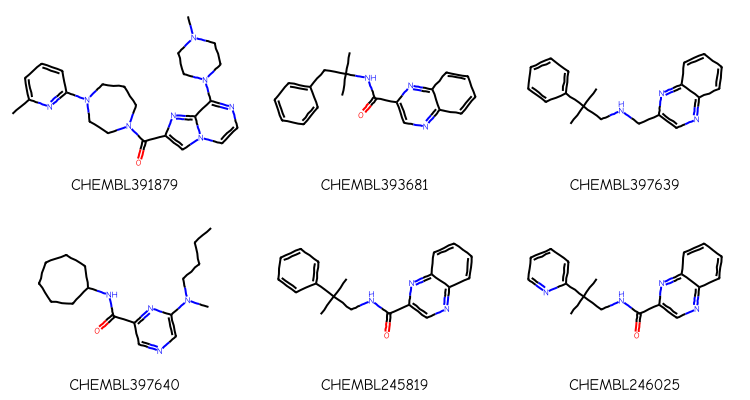

In [62]:
aid = aids[1][0]
structs = %sql postgresql://glandrum@stoat/chembl_33 \
  select distinct on (canonical_smiles) cids.chembl_id compound_chembl_id,canonical_smiles \
    from activities \
        join assays using (assay_id) \
        join compound_structures using (molregno) \
        join chembl_id_lookup cids on (molregno=entity_id and entity_type='COMPOUND')\
    where assays.chembl_id=:aid \
      and standard_type='Ki'

nms,smis = zip(*structs)
mols = [Chem.MolFromSmiles(x) for x in smis]
Draw.MolsToGridImage(mols[:6],legends=nms,subImgSize=(250,200))


20


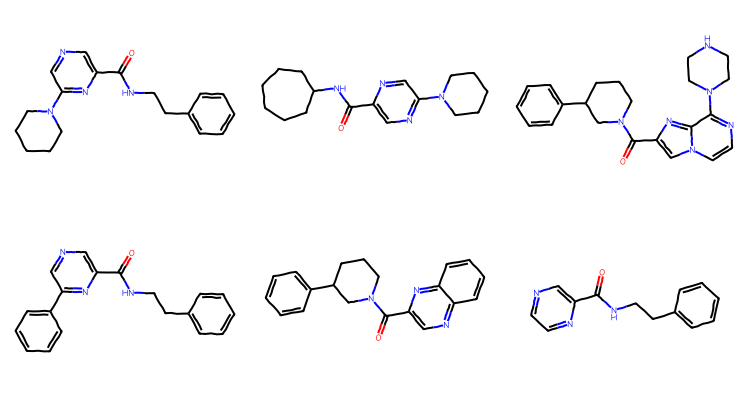

In [63]:
scaffs = []
for m in mols:
    scaff = Chem.MurckoDecompose(m)
    Chem.SanitizeMol(scaff)
    scaffs.append(scaff)
scaff_smis = [Chem.MolToSmiles(x) for x in scaffs]
print(len(set(scaff_smis)))
unique_scaffs = [Chem.MolFromSmiles(smi) for smi in set(scaff_smis)]
Draw.MolsToGridImage(unique_scaffs[:6],subImgSize=(250,200))

Do that in bulk:

In [69]:
%config SqlMagic.feedback = False

accum = []
for aid,_,_ in aids:
    structs = %sql postgresql://glandrum@stoat/chembl_33 \
      select distinct on (canonical_smiles) cids.chembl_id compound_chembl_id,canonical_smiles \
        from activities \
            join assays using (assay_id) \
            join compound_structures using (molregno) \
            join chembl_id_lookup cids on (molregno=entity_id and entity_type='COMPOUND')\
        where assays.chembl_id=:aid \
          and standard_type='Ki'

    nms,smis = zip(*structs)
    mols = [Chem.MolFromSmiles(x) for x in smis]
    scaffs = set()
    for m in mols:
        scaff = Chem.MurckoDecompose(m)
        Chem.SanitizeMol(scaff)
        scaffs.add(Chem.MolToSmiles(scaff))
    accum.append((aid,len(mols),len(scaffs)))
    if not len(accum)%100:
        print(f'Done {len(accum)} of {len(aids)}')

Done 100 of 7148
Done 200 of 7148
Done 300 of 7148
Done 400 of 7148
Done 500 of 7148
Done 600 of 7148
Done 700 of 7148
Done 800 of 7148
Done 900 of 7148
Done 1000 of 7148
Done 1100 of 7148
Done 1200 of 7148
Done 1300 of 7148
Done 1400 of 7148
Done 1500 of 7148
Done 1600 of 7148
Done 1700 of 7148
Done 1800 of 7148
Done 1900 of 7148
Done 2000 of 7148
Done 2100 of 7148
Done 2200 of 7148
Done 2300 of 7148
Done 2400 of 7148
Done 2500 of 7148
Done 2600 of 7148
Done 2700 of 7148
Done 2800 of 7148
Done 2900 of 7148
Done 3000 of 7148
Done 3100 of 7148
Done 3200 of 7148
Done 3300 of 7148
Done 3400 of 7148
Done 3500 of 7148
Done 3600 of 7148
Done 3700 of 7148
Done 3800 of 7148
Done 3900 of 7148
Done 4000 of 7148
Done 4100 of 7148
Done 4200 of 7148
Done 4300 of 7148
Done 4400 of 7148
Done 4500 of 7148
Done 4600 of 7148
Done 4700 of 7148
Done 4800 of 7148
Done 4900 of 7148
Done 5000 of 7148
Done 5100 of 7148
Done 5200 of 7148
Done 5300 of 7148
Done 5400 of 7148
Done 5500 of 7148
Done 5600 of 7148
D

In [70]:
import pickle
with open('./results/murcko_scaffs.pkl','wb+') as outf:
    pickle.dump(accum,outf)

In [3]:
import pickle
with open('./results/murcko_scaffs.pkl','rb') as inf:
    accum = pickle.load(inf)

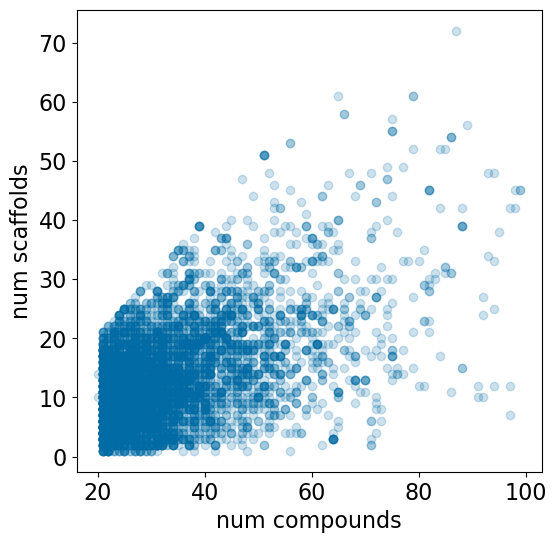

In [4]:
plt.figure(figsize=(6,6))
plt.scatter([x[1] for x in accum],[x[2] for x in accum],alpha=0.2)
plt.xlabel('num compounds')
plt.ylabel('num scaffolds');

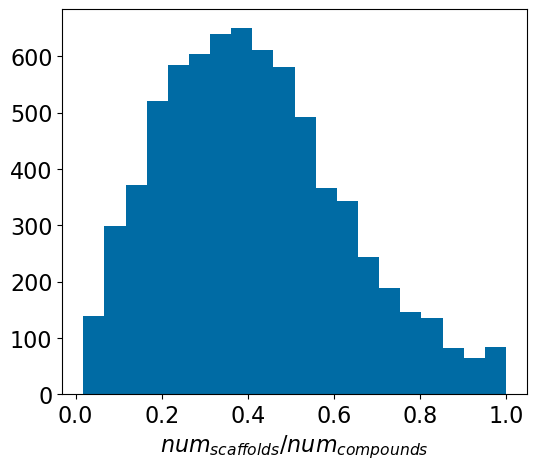

In [5]:
frac = [x[2]/x[1] for x in accum]
plt.figure(figsize=(6,5))
plt.hist(frac,bins=20)
plt.xlabel('$num_{scaffolds} / num_{compounds}$');

# Similarity and the "scaffolds"

In [76]:
%config SqlMagic.feedback = False
mols_by_assay = {}
for aid,_,_ in aids[:100]:
    structs = %sql postgresql://glandrum@stoat/chembl_33 \
      select distinct on (canonical_smiles) cids.chembl_id compound_chembl_id,canonical_smiles \
        from activities \
            join assays using (assay_id) \
            join compound_structures using (molregno) \
            join chembl_id_lookup cids on (molregno=entity_id and entity_type='COMPOUND')\
        where assays.chembl_id=:aid \
          and standard_type='Ki'
    mols_by_assay[aid] = [(cid,Chem.MolFromSmiles(smi)) for cid,smi in structs]

In [77]:
len(mols_by_assay)

100

In [78]:
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3)
fps_by_assay = {}
for aid in mols_by_assay:
    fps_by_assay[aid]  = [fpg.GetFingerprint(m) for cid,m in mols_by_assay[aid]]

In [79]:
accum = {}
scaff_accum = {}
for aid in mols_by_assay:
    scaffs = []
    for cid,m in mols_by_assay[aid]:
        scaff = Chem.MurckoDecompose(m)
        Chem.SanitizeMol(scaff)
        scaffs.append(Chem.MolToSmiles(scaff))
    scaff_accum[aid] = scaffs
    fps = fps_by_assay[aid]
    same_scaff_similarity=[]
    diff_scaff_similarity=[]
    random_similarity=[]
    for i,fp in enumerate(fps):
        sims = DataStructs.BulkTanimotoSimilarity(fp,fps[i+1:])
        for j,sim in enumerate(sims):
            random_similarity.append(sim)
            if scaffs[i]==scaffs[j+i+1]:
                same_scaff_similarity.append(sim)
            else:
                diff_scaff_similarity.append(sim)
    accum[aid] = (same_scaff_similarity,diff_scaff_similarity,random_similarity,len(set(scaffs)))
    

In [80]:
import sys
sys.path.append('/home/glandrum/Code/molecular_time_series/')
import ga_lib_3

In [82]:
from collections import defaultdict
import random
random.seed(0xc00ffee)
scaff_stats_accum = defaultdict(list)
random_stats_accum = defaultdict(list)
for aid in scaff_accum:
    for tscaff in scaff_accum[aid]:
        t_train = [fp for fp,scaff in zip(fps_by_assay[aid],scaff_accum[aid]) if scaff != tscaff]
        t_test = [fp for fp,scaff in zip(fps_by_assay[aid],scaff_accum[aid]) if scaff == tscaff]
        if len(t_test)<5 or len(t_train)<5:
            continue
        _,g,f,s = ga_lib_3.modified_spatial_stats(t_test,t_train,justTheBasics=True)
        scaff_stats_accum[aid].append((np.sum(g),np.sum(f)))
    for tscaff in scaff_accum[aid]:
        n_test = len([scaff for scaff in scaff_accum[aid] if scaff == tscaff])
        if n_test<5:
            continue
        idxs = list(range(len(fps_by_assay[aid])))
        random.shuffle(idxs)
        test_idxs = idxs[:n_test]
        train_idxs = idxs[n_test:]
        t_test = [fps_by_assay[aid][i] for i in test_idxs]
        t_train = [fps_by_assay[aid][i] for i in train_idxs]
        _,g,f,s = ga_lib_3.modified_spatial_stats(t_test,t_train,justTheBasics=True)
        random_stats_accum[aid].append((np.sum(g),np.sum(f)))
        

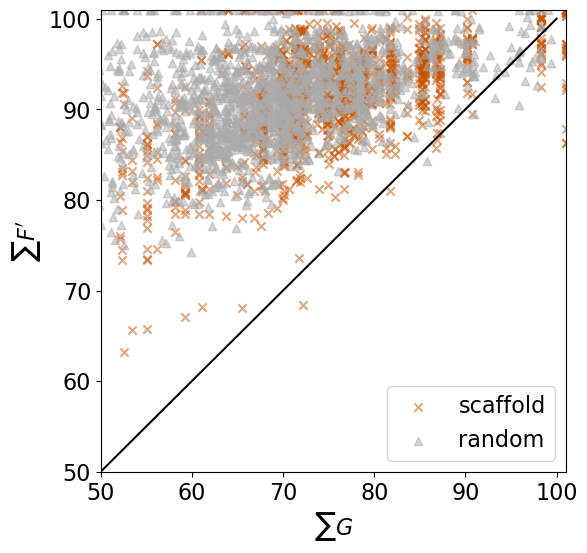

In [93]:
plt.figure(figsize=(6,6))
scaff_gs = []
scaff_fs = []
for aid in scaff_stats_accum:
    scaff_gs.extend(v[0] for v in scaff_stats_accum[aid])
    scaff_fs.extend(v[1] for v in scaff_stats_accum[aid])
random_gs = []
random_fs = []
for aid in random_stats_accum:
    random_gs.extend(v[0] for v in random_stats_accum[aid])
    random_fs.extend(v[1] for v in random_stats_accum[aid])

plt.scatter(scaff_gs,scaff_fs,marker='x',color='C5', alpha=0.5, label='scaffold')
plt.scatter(random_gs,random_fs,marker='^',color='C2', alpha=0.5, label='random')
plt.plot((50,100),(50,100),'k')
plt.ylim(50,101)
plt.xlim(50,101);
plt.xlabel(r'$\sum G$');
plt.ylabel(r"$\sum F'$");
plt.legend();

In [49]:
tscaff

'c1ccc2c(c1)CC[C@H]1NCC[C@H]21'

In [20]:
accum[aid][-1]

17

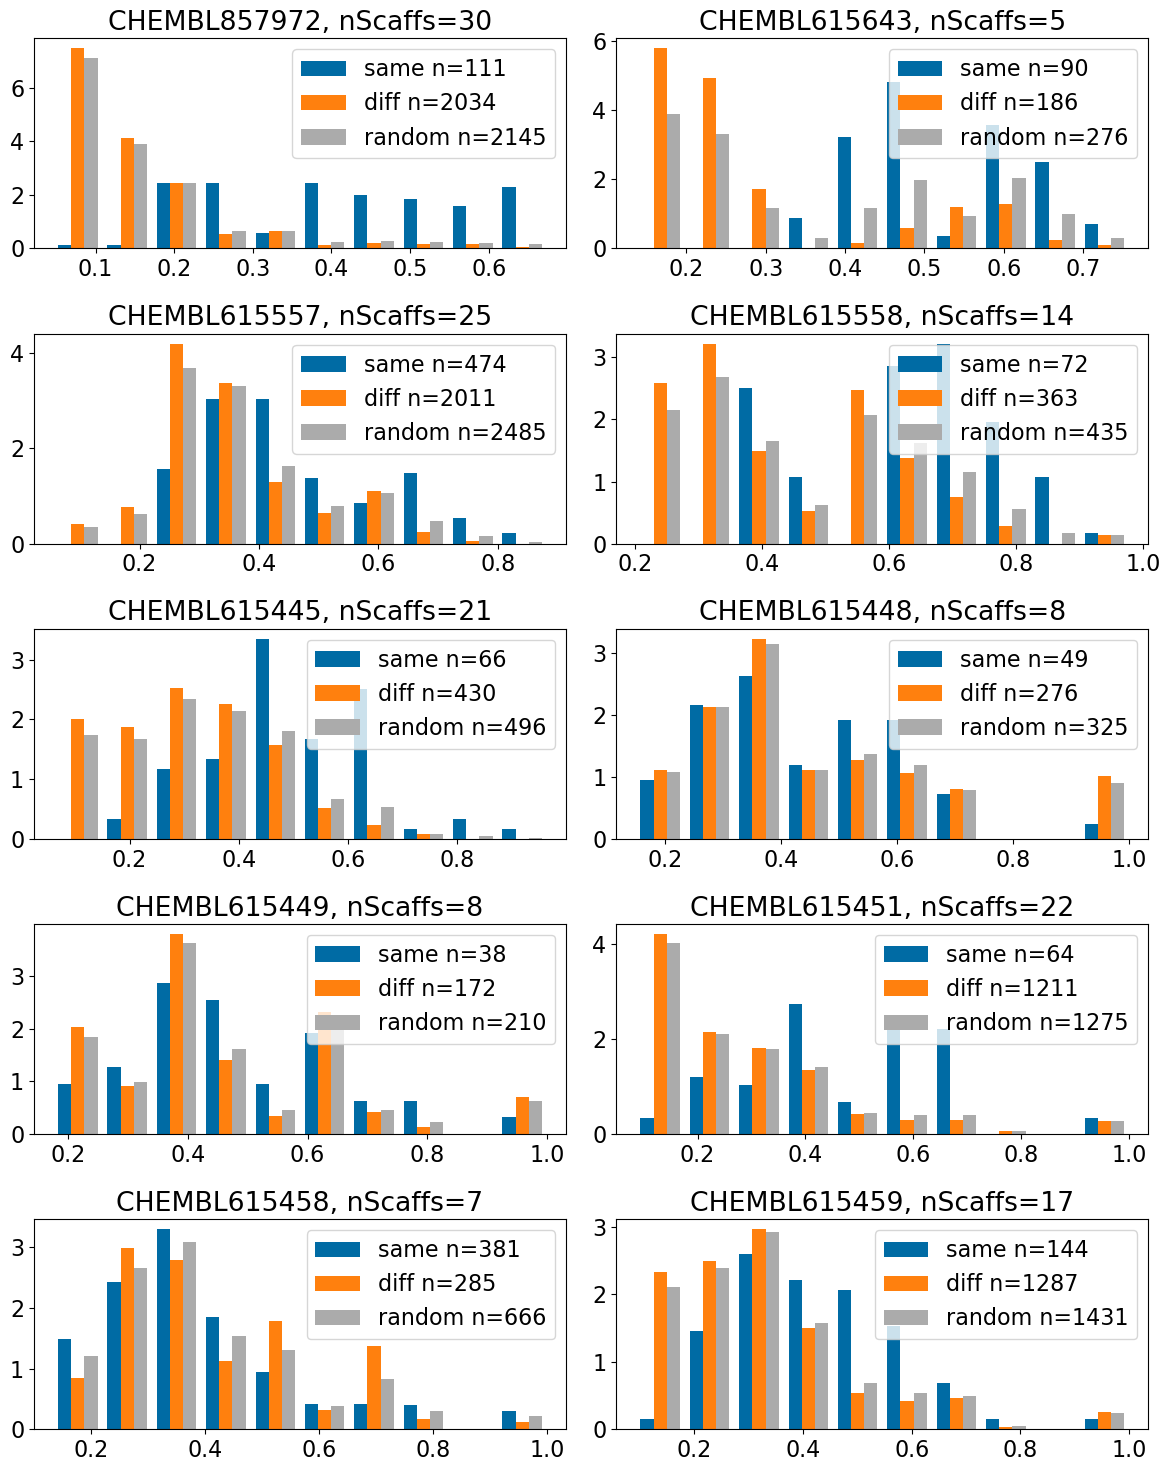

In [21]:
nrows = len(accum)//2
if len(accum)%2:
    nrows += 1
plt.figure(figsize=(12,3*nrows))

for i,aid in enumerate(accum):    
    plt.subplot(nrows,2,i+1)
    plt.hist(accum[aid][:-1],label=(f'same n={len(accum[aid][0])}',f'diff n={len(accum[aid][1])}',f'random n={len(accum[aid][2])}'),density=True);
    plt.legend();
    #plt.xlim((0,1))
    plt.title(f'{aid}, nScaffs={accum[aid][-1]}');
plt.tight_layout();

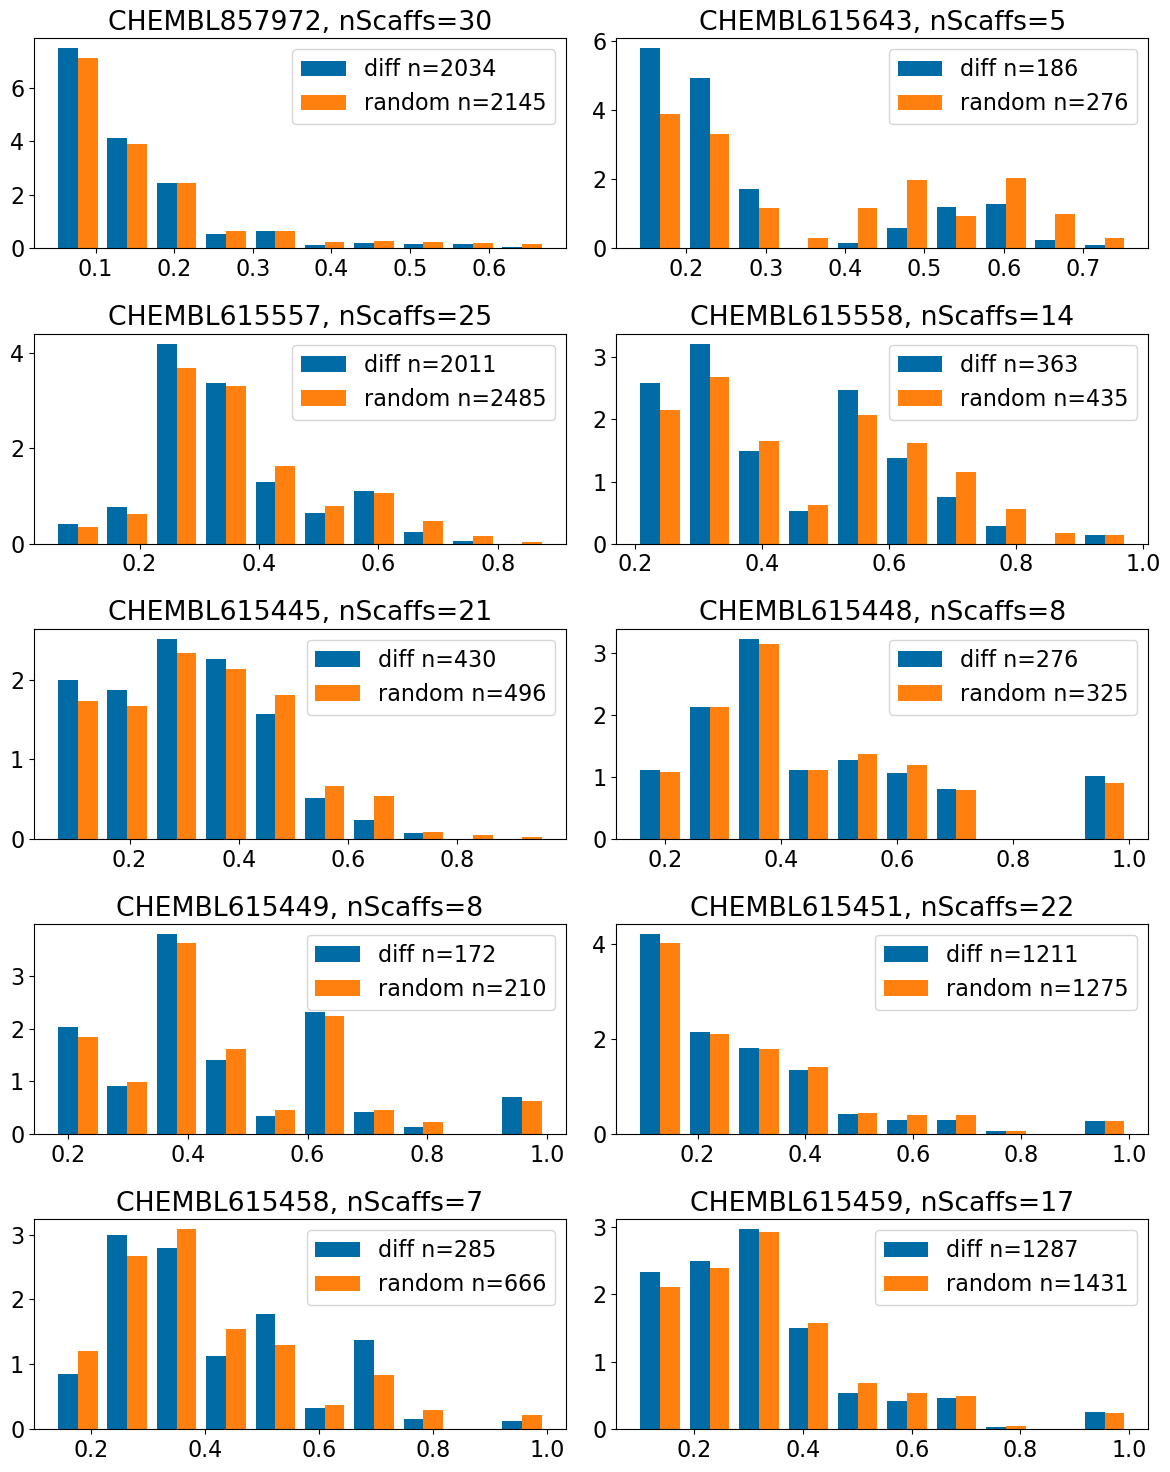

In [22]:
import copy
nrows = len(accum)//2
if len(accum)%2:
    nrows += 1
plt.figure(figsize=(12,3*nrows))

taccum = copy.deepcopy(accum)
for i,aid in enumerate(taccum):
    tpl = taccum[aid][1:]
    plt.subplot(nrows,2,i+1)
    plt.hist(tpl[:-1],label=(f'diff n={len(tpl[0])}',f'random n={len(tpl[1])}'),density=True);
    plt.legend();
    #plt.xlim((0,1))
    plt.title(f'{aid}, nScaffs={accum[aid][-1]}');
plt.tight_layout()